In [1]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
import htmd.ui as ht
import htmd.molecule.voxeldescriptors as vd
import htmd.vmdviewer as vmdviewer
import csv
import pickle
import numpy as np
from tqdm import *
import bcolz as bc
import glob
import os
import random
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

/usr/local/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. 
https://dx.doi.org/10.1021/acs.jctc.6b00049
Documentation: http://software.acellera.com/
To update: conda update htmd -c acellera -c psi4

New devel HTMD version (1.12.3 python[3.6,<3.7.0a0,3.5,<3.6.0a0]) is available. You are currently on (1.9.10). Use 'conda update -c acellera htmd' to update to the new version. You might need to update your python version as well if there is no release for your current version.

Deprecation warning: "from htmd import *" will be deprecated. 
To import all HTMD shortcuts please from now on use "from htmd.ui import *"


In [20]:
%matplotlib inline
bc.set_nthreads = 8

In [3]:
def get_model1(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     input_shape=(24, 24, 24, 16),
                     padding='same',
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     bias_initializer='zeros'))
    
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 2nd layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 3rd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 4th layer group
#     model.add(Conv3D(filters=128,
#                      kernel_size=(3, 3, 3),
#                      activation='relu',
#                      padding='valid'))
    
#     model.add(MaxPooling3D(pool_size=(2, 2, 2),
#                            #strides=(1, 1, 1),
#                            padding='valid'))
    
    #model.add(AveragePooling3D(pool_size=(2, 2, 2), 
    #                           padding='valid'))
                           
    model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(256, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [4]:
def get_model2(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     input_shape=(24, 24, 24, 16),
                     padding='same',
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     bias_initializer='zeros'))
    
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 2nd layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 3rd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(Conv3D(filters=32,
                    kernel_size=(1, 1, 1),
                    strides = (1, 1, 1), 
                    activation = 'relu',
                    padding = 'same'))
                           
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [5]:
def get_model3(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     input_shape=(50, 50, 50, 16),
                     padding='same',
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     bias_initializer='zeros'))
    
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 2nd layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 3rd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 4th layer group
#     model.add(Conv3D(filters=128,
#                      kernel_size=(3, 3, 3),
#                      activation='relu',
#                      padding='valid'))
    
#     model.add(MaxPooling3D(pool_size=(2, 2, 2),
#                            #strides=(1, 1, 1),
#                            padding='valid'))
    
    #model.add(AveragePooling3D(pool_size=(2, 2, 2), 
    #                           padding='valid'))
                           
    model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(256, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [6]:
get_model3(summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 50, 50, 50, 32)    13856     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 50, 50, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 25, 25, 25, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 25, 25, 25, 64)    55360     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 25, 25, 25, 64)    110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 12, 12, 64)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 12, 12, 12, 128)   221312    
__________

In [7]:
with open('data_x.pickle', 'rb') as f:
    data_x = pickle.load(f)
with open('data_y.pickle', 'rb') as f:
    data_y = pickle.load(f)

data_x.shape, data_y.shape

((3794, 24, 24, 24, 16), (3794,))

In [7]:
bc_data_x = bc.open("data_x_50/")
with open("data_y_50.pickle", "rb") as f:
    bc_data_y = pickle.load(f)
bc_data_x.shape, bc_data_y.shape

((3658, 50, 50, 50, 16), (3658,))

In [8]:
def batch_generator(batch_size):
    global bc_data_x, bc_data_y
    
    while True:
        rand_ids = np.random.choice(bc_data_x.shape[0] - 1000, batch_size) # Saving last 1000 for test
        yield bc_data_x[rand_ids], bc_data_y[rand_ids]

In [16]:
%time bx, by = next(batch_generator(10))
bx.shape

CPU times: user 255 ms, sys: 340 ms, total: 594 ms
Wall time: 244 ms


(10, 50, 50, 50, 16)

In [8]:
limit = 3500
train_x, train_y = data_x[:limit], data_y[:limit]
test_x, test_y = data_x[-100:], data_y[-100:]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((3500, 24, 24, 24, 16), (3500,), (100, 24, 24, 24, 16), (100,))

In [22]:
nb_gpus = 8
nb_batch = nb_gpus*32
nb_epochs = 100
l_rate = 0.00001

In [23]:
model = get_model3()
model = multi_gpu_model(model, gpus=nb_gpus)
model.compile(optimizer=optimizers.rmsprop(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [24]:
history3 = model.fit_generator(generator=batch_generator(batch_size=nb_batch), 
                               epochs=nb_epochs, 
                               steps_per_epoch=bc_data_x.shape[0]//nb_batch, 
                               verbose=1)

Epoch 1/100
14/14 [==============================] - 51s 4s/step - loss: 28.3830 - mean_squared_error: 28.3830
Epoch 2/100
14/14 [==============================] - 48s 3s/step - loss: 4.4050 - mean_squared_error: 4.4050
Epoch 3/100
14/14 [==============================] - 47s 3s/step - loss: 3.2533 - mean_squared_error: 3.2533
Epoch 4/100
14/14 [==============================] - 46s 3s/step - loss: 3.2563 - mean_squared_error: 3.2563
Epoch 5/100
14/14 [==============================] - 47s 3s/step - loss: 3.2907 - mean_squared_error: 3.2907
Epoch 6/100
14/14 [==============================] - 47s 3s/step - loss: 3.2661 - mean_squared_error: 3.2661
Epoch 7/100
14/14 [==============================] - 46s 3s/step - loss: 3.2528 - mean_squared_error: 3.2528
Epoch 8/100
14/14 [==============================] - 47s 3s/step - loss: 3.2058 - mean_squared_error: 3.2058
Epoch 9/100
14/14 [==============================] - 47s 3s/step - loss: 3.1964 - mean_squared_error: 3.1964
Epoch 10/100
14/1

14/14 [==============================] - 47s 3s/step - loss: 2.4615 - mean_squared_error: 2.4615
Epoch 76/100
14/14 [==============================] - 48s 3s/step - loss: 2.4995 - mean_squared_error: 2.4995
Epoch 77/100
14/14 [==============================] - 48s 3s/step - loss: 2.5099 - mean_squared_error: 2.5099
Epoch 78/100
14/14 [==============================] - 47s 3s/step - loss: 2.5035 - mean_squared_error: 2.5035
Epoch 79/100
14/14 [==============================] - 48s 3s/step - loss: 2.4037 - mean_squared_error: 2.4037
Epoch 80/100
14/14 [==============================] - 47s 3s/step - loss: 2.4558 - mean_squared_error: 2.4558
Epoch 81/100
14/14 [==============================] - 48s 3s/step - loss: 2.4934 - mean_squared_error: 2.4934
Epoch 82/100
14/14 [==============================] - 47s 3s/step - loss: 2.4984 - mean_squared_error: 2.4984
Epoch 83/100
14/14 [==============================] - 47s 3s/step - loss: 2.4267 - mean_squared_error: 2.4267
Epoch 84/100
14/14 [===

In [24]:
# history2 = model.fit(x=bc_data_x, y=bc_data_y, epochs=nb_epochs, batch_size=nb_batch, verbose=1)

In [25]:
weight_file = 'weights_3_50.h5'
model.save_weights(weight_file)

In [26]:
with open("history_3.pickle", "wb") as f:
    pickle.dump(history3.history, f)
mdl = get_model3()
mdl.save("model_3.model")

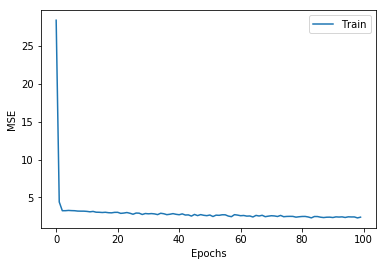

In [27]:
plt.figure()
plt.plot(history3.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(['Train'])
plt.show()

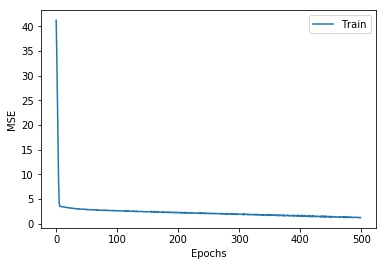

In [61]:
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(['Train'])
plt.show()

In [28]:
eval_model = get_model3()
eval_model = multi_gpu_model(eval_model, gpus=4)
eval_model.load_weights(weight_file)
eval_model.compile(optimizer=optimizers.rmsprop(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [29]:
train_x, train_y = bc_data_x[:1000], bc_data_y[:1000]
test_x, test_y = bc_data_x[-1000:], bc_data_y[-1000:]
print(test_x.shape, test_y.shape)
train_r2 = r2_score(y_pred=eval_model.predict(train_x), y_true=train_y)
test_r2 = r2_score(y_pred=eval_model.predict(test_x), y_true=test_y)
print("Train R2: %0.3f , Test R2: %0.3f" % (train_r2, test_r2))

(1000, 50, 50, 50, 16) (1000,)
Train R2: 0.439 , Test R2: 0.277


In [64]:
train_r2 = r2_score(y_pred=eval_model.predict(train_x), y_true=train_y)
test_r2 = r2_score(y_pred=eval_model.predict(test_x), y_true=test_y)
print("Train R2: %0.3f , Test R2: %0.3f" % (train_r2, test_r2))

Train R2: 0.741 , Test R2: 0.327


### Best result so far <br>
500 epochs<br>
l_rate = 0.0001

In [45]:
l_rate = 0.00001
eval_model = get_model1()
eval_model = multi_gpu_model(eval_model, gpus=4)
eval_model.load_weights('weights_2.h5')
eval_model.compile(optimizer=optimizers.rmsprop(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [46]:
train_r2 = r2_score(y_pred=eval_model.predict(train_x), y_true=train_y)
test_r2 = r2_score(y_pred=eval_model.predict(test_x), y_true=test_y)
print("Train R2: %0.3f , Test R2: %0.3f" % (train_r2, test_r2))

Train R2: 0.789 , Test R2: 0.454


# Report

### Model 1:

Weights file: "weights_2.h5" <br>
Epochs: 500 <br>
Learning rate: 0.00001 <br>
Without coordinate transformation<br>
data_shape = (3500, 24, 24, 24, 16)<br>

#### Architecture

```
Layer (type)                 Output Shape              Param #   
=================================================================
conv3d_106 (Conv3D)          (None, 24, 24, 24, 32)    13856     
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 24, 24, 24, 32)    27680     
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 12, 12, 12, 32)    0         
_________________________________________________________________
conv3d_108 (Conv3D)          (None, 12, 12, 12, 64)    55360     
_________________________________________________________________
conv3d_109 (Conv3D)          (None, 12, 12, 12, 64)    110656    
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 6, 6, 6, 64)       0         
_________________________________________________________________
conv3d_110 (Conv3D)          (None, 6, 6, 6, 128)      221312    
_________________________________________________________________
conv3d_111 (Conv3D)          (None, 6, 6, 6, 128)      442496    
_________________________________________________________________
max_pooling3d_42 (MaxPooling (None, 3, 3, 3, 128)      0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 3456)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               884992    
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 257       
=================================================================
Total params: 1,756,609
Trainable params: 1,756,609
Non-trainable params: 0
```


#### Results
Train R2: <b>0.789</b> , Test R2: <b>0.454</b>

### Model 2
Modifications: <br>
<ul>
    <li>Replacing the last max-pooling layer by 1-1 conv. layer</li>
</ul>

Weights file: 'weights_2-conv-1-1.h5'<br>
Without coordinate transformation<br>
data_shape = (3500, 24, 24, 24, 16)<br>

#### Architecture:
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv3d_112 (Conv3D)          (None, 24, 24, 24, 16)    6928      
_________________________________________________________________
conv3d_113 (Conv3D)          (None, 24, 24, 24, 16)    6928      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 12, 12, 12, 16)    0         
_________________________________________________________________
conv3d_114 (Conv3D)          (None, 12, 12, 12, 32)    13856     
_________________________________________________________________
conv3d_115 (Conv3D)          (None, 12, 12, 12, 32)    27680     
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 6, 6, 6, 32)       0         
_________________________________________________________________
conv3d_116 (Conv3D)          (None, 6, 6, 6, 64)       55360     
_________________________________________________________________
conv3d_117 (Conv3D)          (None, 6, 6, 6, 64)       110656    
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 3, 3, 3, 64)       0         
_________________________________________________________________
conv3d_118 (Conv3D)          (None, 3, 3, 3, 128)      221312    
_________________________________________________________________
conv3d_119 (Conv3D)          (None, 3, 3, 3, 128)      442496    
_________________________________________________________________
conv3d_120 (Conv3D)          (None, 3, 3, 3, 32)       4128      
_________________________________________________________________
flatten_15 (Flatten)         (None, 864)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               442880    
_________________________________________________________________
dense_39 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 257       
=================================================================
Total params: 1,463,809
Trainable params: 1,463,809
Non-trainable params: 0
_________________________________________________________________
```

#### Results:
Train R2: 0.741 , Test R2: 0.327


### Model 3

Weights file: 'weights_3_50.h5'<br>
Without coordinate transformation<br>
data_shape = (50, 50, 50, 16)<br>

#### Architecture: <br>
```
Layer (type)                 Output Shape              Param #   
=================================================================
conv3d_1 (Conv3D)            (None, 50, 50, 50, 32)    13856     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 50, 50, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 25, 25, 25, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 25, 25, 25, 64)    55360     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 25, 25, 25, 64)    110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 12, 12, 64)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 12, 12, 12, 128)   221312    
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 12, 12, 12, 128)   442496    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 6, 6, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 27648)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               7078144   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
=================================================================
Total params: 7,949,761
Trainable params: 7,949,761
Non-trainable params: 0
```


#### Results:
Train R2: 0.439, Test R2: 0.277
